In [2]:
import h5py
import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# from gaiaunlimited.scanninglaw import GaiaScanningLaw

In [3]:
# nside = 64
nside = 100

with h5py.File(f"../scripts/data/scanlaw_nside{nside}_dr3.h5", "r") as f:
    meta = dict(f.attrs)
    scans = f["index/scans_per_pixel"][:]
    scan_pix = f["index/pixels"][:]

scans_map = np.zeros(hp.nside2npix(nside))
scans_map[scan_pix] = scans
scans_ra, scans_dec = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)), lonlat=True)
scans_ra[scans_ra >= 180] -= 360

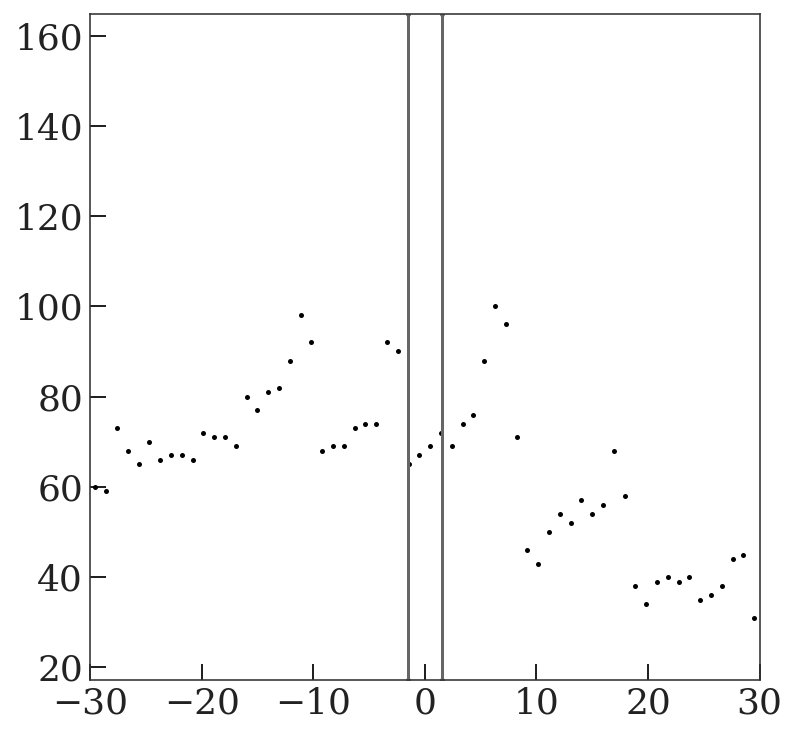

In [4]:
_mask = (scans_dec > 45) & (scans_dec < 48)
val = scans_dec[_mask].min()
_mask = np.isclose(scans_dec, val)
plt.plot(scans_ra[_mask], scans_map[_mask], ls="none")
plt.xlim(-30, 30)
plt.axvline(1.5)
plt.axvline(-1.5)

In [5]:
two_idx = np.where(_mask & (np.abs(scans_ra) < 1.5))[0]

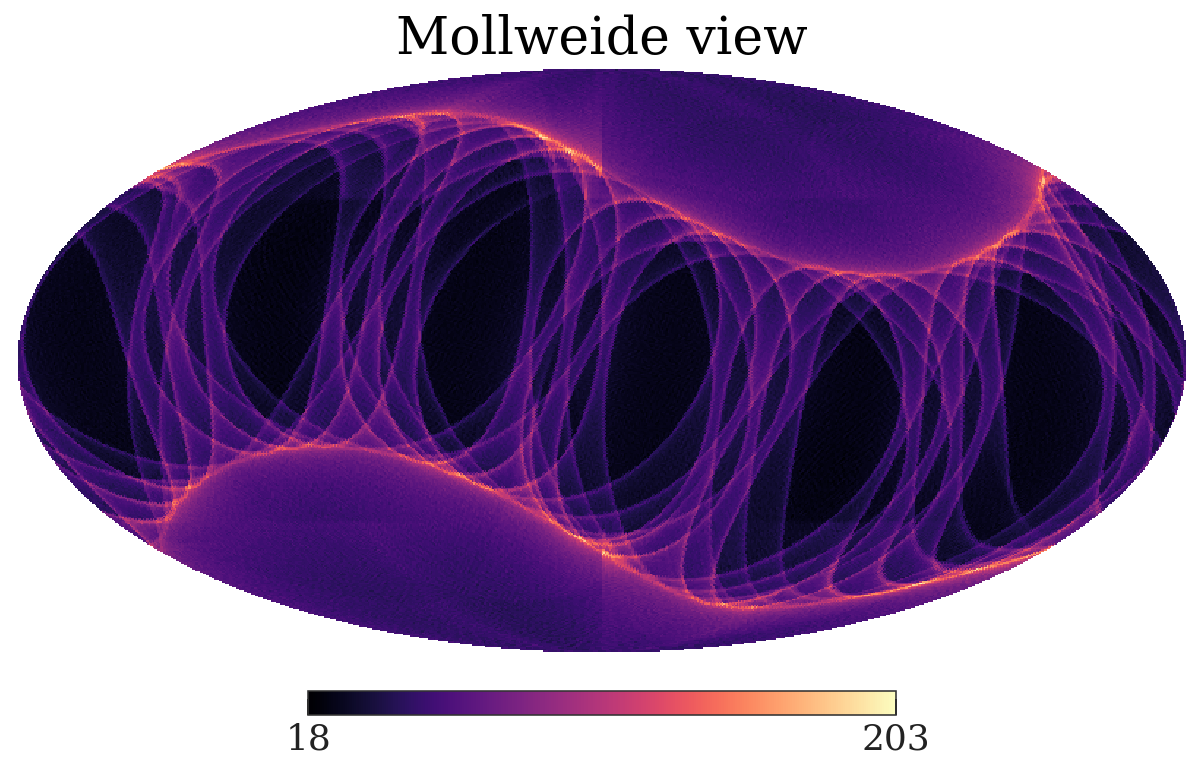

In [6]:
tmp = scans_map.copy()
# tmp[_mask] = np.nan
# hp.mollview(scans_map)
hp.mollview(tmp)

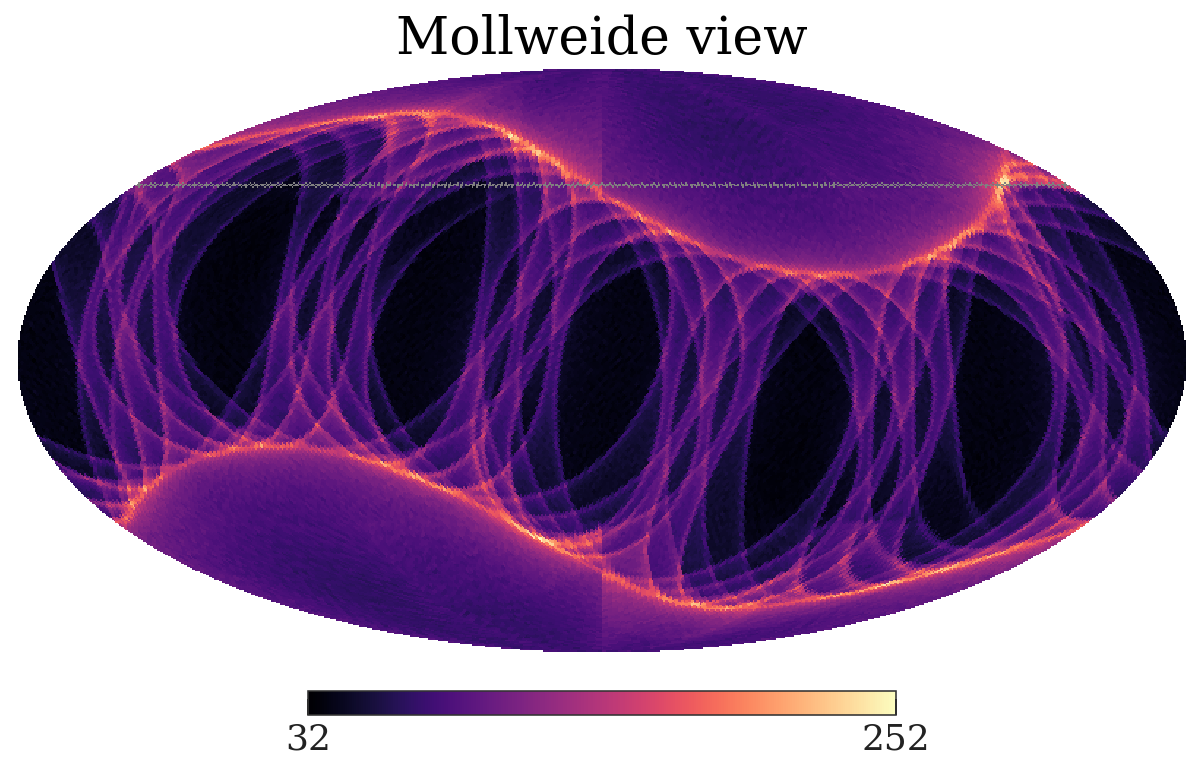

In [6]:
tmp = scans_map.copy()
tmp[_mask] = np.nan
# hp.mollview(scans_map)
hp.mollview(tmp)

In [ ]:
scan_law = GaiaScanningLaw("dr3_nominal")

In [ ]:
ra, dec = hp.pix2ang(64, np.arange(hp.nside2npix(64)), lonlat=True, nest=False)
gu_scans = [sum(scan_law.query(ra[i], dec[i], count_only=True)) for i in range(len(ra))]
gu_scans = np.array(gu_scans)

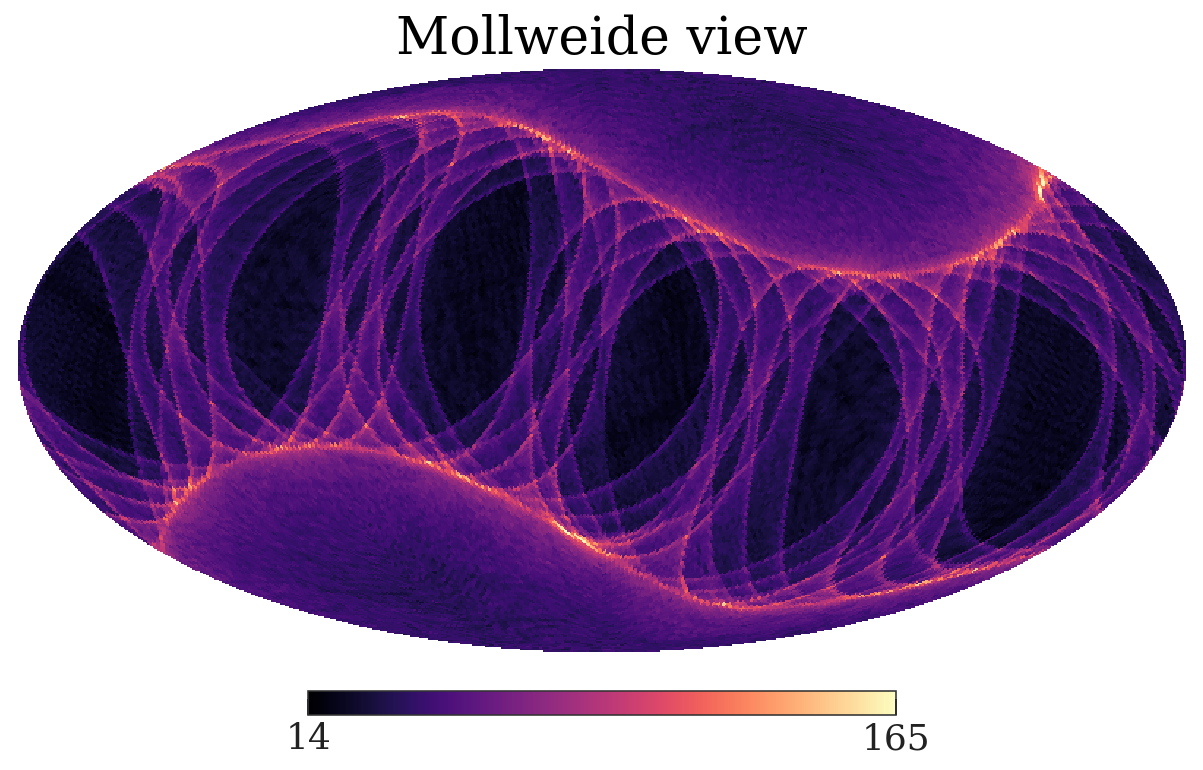

In [ ]:
hp.mollview(gu_scans)

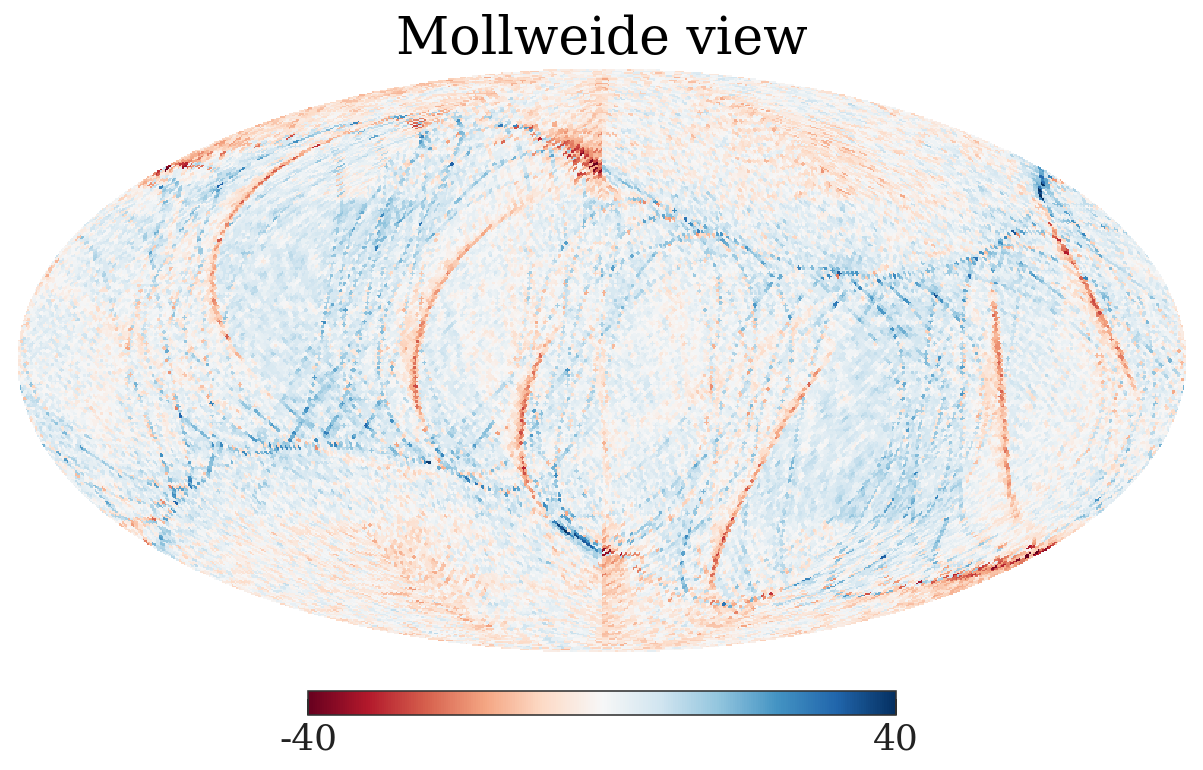

In [ ]:
hp.mollview(
    gu_scans - np.median(gu_scans) / np.median(scans) * scans,
    min=-40,
    max=40,
    cmap="RdBu",
)

In [ ]:
import pandas as pd

scan_law_file = (
    "/mnt/ceph/users/gaia/scanninglaw/FullGaiaMissionScanningLaw/commanded_scan_law.csv"
)
df = pd.read_csv(
    scan_law_file,
    comment="#",
)

In [ ]:
fov_num = 1
ra = df[f"ra_fov{fov_num}"].to_numpy()
dec = df[f"dec_fov{fov_num}"].to_numpy()

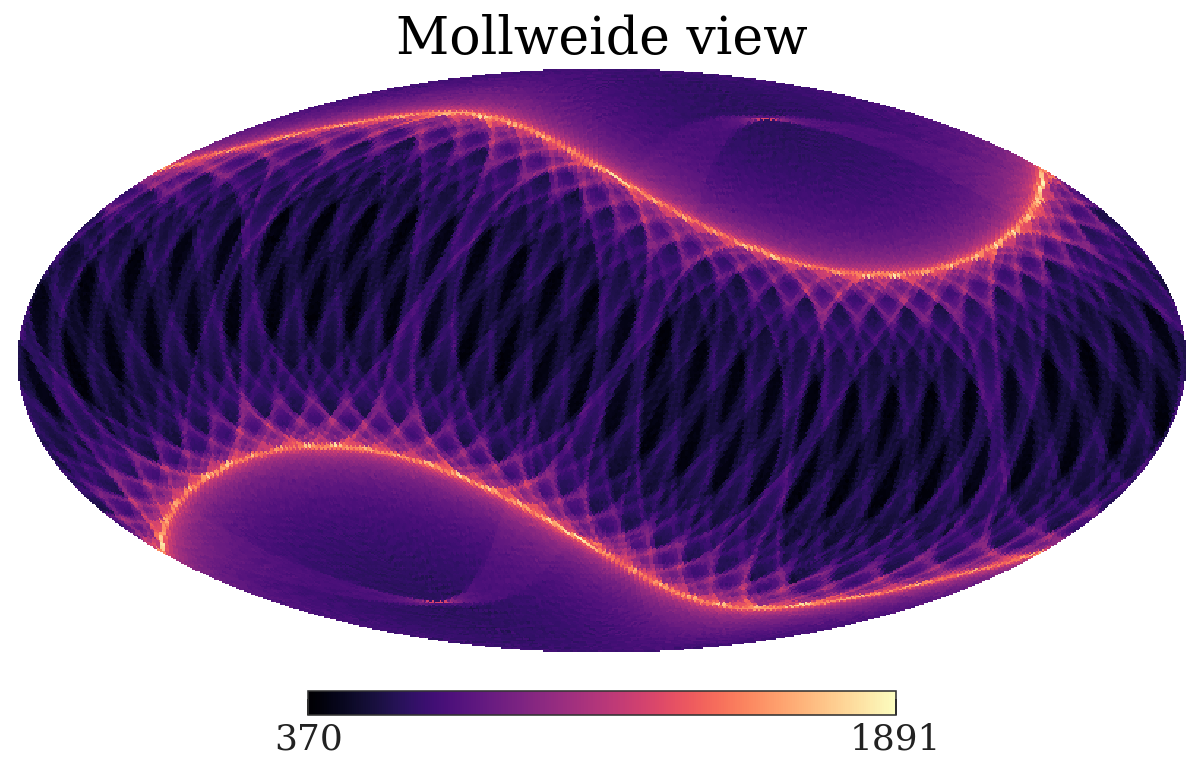

In [ ]:
indices = hp.ang2pix(64, ra, dec, lonlat=True, nest=False)

idx, counts = np.unique(indices, return_counts=True)
hpx_map = np.zeros(hp.nside2npix(64), dtype=int)
hpx_map[idx] = counts

hp.mollview(hpx_map)

In [ ]:
def _scan_start_mask(times: np.ndarray, scan_gap_days: float) -> np.ndarray:
    if times.size == 0:
        return np.zeros(0, dtype=bool)
    order = np.argsort(times)
    sorted_times = times[order]
    gaps = np.diff(sorted_times) > scan_gap_days
    scan_starts = np.r_[True, gaps]
    mask = np.zeros(times.size, dtype=bool)
    mask[order[scan_starts]] = True
    return mask


def find_unique_scans(
    times: np.ndarray, pixel_ids: np.ndarray, scan_gap_days: float
) -> np.ndarray:
    result = np.zeros(len(times), dtype=bool)
    for pix in np.unique(pixel_ids):
        pix_mask = pixel_ids == pix
        result[pix_mask] = _scan_start_mask(times[pix_mask], scan_gap_days)
    return result


ra = df[f"ra_fov{fov_num}"].to_numpy()
dec = df[f"dec_fov{fov_num}"].to_numpy()
times = df[f"bjd_fov{fov_num}"].to_numpy()
valid = np.isfinite(ra) & np.isfinite(dec)

nside = 64
# Compute HEALPix for valid observations
pix = hp.ang2pix(nside, ra[valid], dec[valid], nest=False, lonlat=True)

# Identify unique scans (one per scan transit, not one per 10s sample)
unique_scan_mask = find_unique_scans(times[valid], pix, scan_gap_days=0.2)
# unique_scan_mask = find_unique_scans(times[valid], pix, scan_gap_days=1e-3)

KeyboardInterrupt: 

In [ ]:
valid.sum(), unique_scan_mask.sum()

(np.int64(34504372), np.int64(7809409))

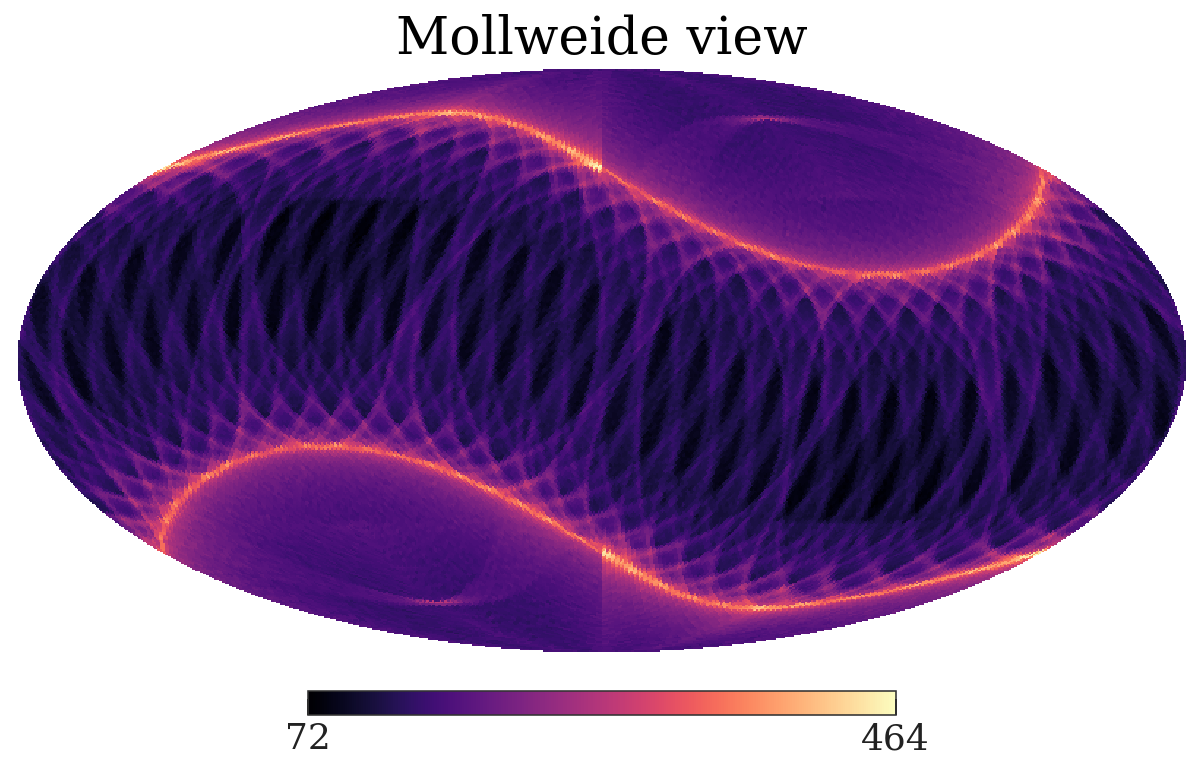

In [ ]:
indices = hp.ang2pix(
    64,
    ra[valid][unique_scan_mask],
    dec[valid][unique_scan_mask],
    lonlat=True,
    nest=False,
)

idx, counts = np.unique(indices, return_counts=True)
hpx_map = np.zeros(hp.nside2npix(64), dtype=int)
hpx_map[idx] = counts

hp.mollview(hpx_map)

In [ ]:
# Diagnostic: look at scans near RA=0 boundary
# Find observations near RA=0
boundary_mask = (np.abs(ra[valid][unique_scan_mask]) < 5) | (
    np.abs(ra[valid][unique_scan_mask] - 360) < 5
)
boundary_obs = np.where(boundary_mask)[0][:100]  # First 100 near boundary

print(f"Found {boundary_mask.sum()} scans near RA=0/360 boundary")
print("\nFirst few scans near boundary:")
for i in boundary_obs[:10]:
    print(
        f"  RA={ra[valid][unique_scan_mask][i]:7.2f}, Dec={dec[valid][unique_scan_mask][i]:7.2f}, "
        f"Time={times[valid][unique_scan_mask][i]:12.3f}, Pix={indices[i]}"
    )

Found 227619 scans near RA=0/360 boundary

First few scans near boundary:
  RA= 355.13, Dec= -20.06, Time=    1666.606, Pix=33149
  RA= 355.27, Dec= -20.37, Time=    1666.606, Pix=33404
  RA= 355.57, Dec= -20.97, Time=    1666.606, Pix=33661
  RA= 356.02, Dec= -21.88, Time=    1666.607, Pix=33917
  RA= 356.39, Dec= -22.64, Time=    1666.608, Pix=34173
  RA= 356.47, Dec= -22.79, Time=    1666.608, Pix=34429
  RA= 356.93, Dec= -23.69, Time=    1666.608, Pix=34686
  RA= 357.40, Dec= -24.60, Time=    1666.609, Pix=34942
  RA= 357.63, Dec= -25.05, Time=    1666.609, Pix=35198
  RA= 357.87, Dec= -25.50, Time=    1666.610, Pix=35454


In [ ]:
# Let's trace through a specific scan that crosses RA=0
# Find a sequence of consecutive 10s samples that cross the boundary
all_ra = ra[valid]
all_dec = dec[valid]
all_times = times[valid]
all_pix = pix

# Find where RA wraps around (large jump in RA)
ra_diff = np.abs(np.diff(all_ra))
wraps = np.where(ra_diff > 180)[0][:5]  # First 5 wrap-around points

print(f"Found {len(np.where(ra_diff > 180)[0])} RA wrap-around points")
print("\nExamining first wrap-around:")
if len(wraps) > 0:
    idx = wraps[0]
    for i in range(max(0, idx - 3), min(len(all_ra), idx + 4)):
        is_unique = unique_scan_mask[i]
        print(
            f"  [{i}] RA={all_ra[i]:7.2f}, Dec={all_dec[i]:6.2f}, "
            f"Time={all_times[i]:12.3f}, Pix={all_pix[i]:5d}, "
            f"UniqueScan={'***' if is_unique else '   '}"
        )

Found 15966 RA wrap-around points

Examining first wrap-around:
  [1467] RA= 359.67, Dec=-28.80, Time=    1666.612, Pix=36479, UniqueScan=   
  [1468] RA= 359.75, Dec=-28.94, Time=    1666.612, Pix=36480, UniqueScan=***
  [1469] RA= 359.84, Dec=-29.09, Time=    1666.612, Pix=36480, UniqueScan=   
  [1470] RA= 359.92, Dec=-29.24, Time=    1666.612, Pix=36480, UniqueScan=   
  [1471] RA=   0.01, Dec=-29.39, Time=    1666.612, Pix=36480, UniqueScan=   
  [1472] RA=   0.09, Dec=-29.54, Time=    1666.613, Pix=36480, UniqueScan=   
  [1473] RA=   0.18, Dec=-29.69, Time=    1666.613, Pix=36480, UniqueScan=   


In [ ]:
# Let's look at more context - show 20 samples around the wrap
if len(wraps) > 0:
    idx = wraps[0]
    print("\nExpanded view (20 samples):")
    for i in range(max(0, idx - 10), min(len(all_ra), idx + 10)):
        is_unique = unique_scan_mask[i]
        time_gap = (
            0 if i == 0 else (all_times[i] - all_times[i - 1]) * 24 * 3600
        )  # in seconds
        pix_change = (
            "" if i == 0 else ("PIXCHG" if all_pix[i] != all_pix[i - 1] else "")
        )
        print(
            f"  [{i:5d}] RA={all_ra[i]:7.2f}, Pix={all_pix[i]:5d}, "
            f"ΔT={time_gap:6.1f}s {pix_change:6s} Unique={'***' if is_unique else '   '}"
        )


Expanded view (20 samples):
  [ 1460] RA= 359.09, Pix=35967, ΔT=   9.6s        Unique=   
  [ 1461] RA= 359.17, Pix=36223, ΔT=   9.6s PIXCHG Unique=***
  [ 1462] RA= 359.25, Pix=36479, ΔT=   9.6s PIXCHG Unique=***
  [ 1463] RA= 359.34, Pix=36479, ΔT=   9.5s        Unique=   
  [ 1464] RA= 359.42, Pix=36479, ΔT=   9.5s        Unique=   
  [ 1465] RA= 359.50, Pix=36479, ΔT=   9.5s        Unique=   
  [ 1466] RA= 359.59, Pix=36479, ΔT=   9.5s        Unique=   
  [ 1467] RA= 359.67, Pix=36479, ΔT=   9.5s        Unique=   
  [ 1468] RA= 359.75, Pix=36480, ΔT=   9.5s PIXCHG Unique=***
  [ 1469] RA= 359.84, Pix=36480, ΔT=   9.5s        Unique=   
  [ 1470] RA= 359.92, Pix=36480, ΔT=   9.5s        Unique=   
  [ 1471] RA=   0.01, Pix=36480, ΔT=   9.5s        Unique=   
  [ 1472] RA=   0.09, Pix=36480, ΔT=   9.5s        Unique=   
  [ 1473] RA=   0.18, Pix=36480, ΔT=   9.5s        Unique=   
  [ 1474] RA=   0.27, Pix=36736, ΔT=   9.5s PIXCHG Unique=***
  [ 1475] RA=   0.35, Pix=36736, ΔT=   9.

In [ ]:
# Check if the input data is actually sorted by time
print("Are times sorted?", np.all(np.diff(times[valid]) >= 0))
print("First 20 time differences (days):")
print(np.diff(times[valid][:20]))

Are times sorted? False
First 20 time differences (days):
[0.00010819 0.00010822 0.00010824 0.00010827 0.0001083  0.00010833
 0.00010836 0.00010839 0.00010841 0.00010844 0.00010847 0.0001085
 0.00010853 0.00010856 0.00010859 0.00010861 0.00010864 0.00010867
 0.0001087 ]


In [ ]:
# Let's verify what lexsort((pixel_ids, times)) actually does
test_times = np.array([3, 1, 2, 1, 3])
test_pix = np.array([10, 20, 10, 10, 20])

sort_idx = np.lexsort((test_pix, test_times))
print("Test data:")
print("  times:", test_times)
print("  pix:  ", test_pix)
print("\nAfter np.lexsort((pix, times)):")
print("  Sorted times:", test_times[sort_idx])
print("  Sorted pix:  ", test_pix[sort_idx])
print("\nThis shows that times is the PRIMARY sort key (sorts by time first)")

Test data:
  times: [3 1 2 1 3]
  pix:   [10 20 10 10 20]

After np.lexsort((pix, times)):
  Sorted times: [1 1 2 3 3]
  Sorted pix:   [10 20 10 10 20]

This shows that times is the PRIMARY sort key (sorts by time first)


In [ ]:
# Let's look at what actually happens AFTER sorting by time
# This will show us the temporal sequence as the function sees it
sort_idx = np.argsort(times[valid])
sorted_times = times[valid][sort_idx]
sorted_ra = ra[valid][sort_idx]
sorted_dec = dec[valid][sort_idx]
sorted_pix = pix[sort_idx]

# Find RA wraps in the TIME-SORTED data
sorted_ra_diff = np.abs(np.diff(sorted_ra))
sorted_wraps = np.where(sorted_ra_diff > 180)[0][:5]

print(f"In TIME-SORTED data, found {len(np.where(sorted_ra_diff > 180)[0])} RA wraps")
print("\nFirst RA wrap in time-sorted data:")
if len(sorted_wraps) > 0:
    idx = sorted_wraps[0]
    for i in range(max(0, idx - 5), min(len(sorted_ra), idx + 6)):
        dt = 0 if i == 0 else (sorted_times[i] - sorted_times[i - 1]) * 24 * 3600
        pix_chg = (
            "" if i == 0 else ("PIXCHG" if sorted_pix[i] != sorted_pix[i - 1] else "")
        )
        print(
            f"  [{i:5d}] RA={sorted_ra[i]:7.2f}, Dec={sorted_dec[i]:6.2f}, "
            f"Pix={sorted_pix[i]:5d}, ΔT={dt:6.1f}s {pix_chg:6s}"
        )

In TIME-SORTED data, found 15974 RA wraps

First RA wrap in time-sorted data:
  [ 1465] RA= 359.50, Dec=-28.50, Pix=36479, ΔT=   9.5s       
  [ 1466] RA= 359.59, Dec=-28.65, Pix=36479, ΔT=   9.5s       
  [ 1467] RA= 359.67, Dec=-28.80, Pix=36479, ΔT=   9.5s       
  [ 1468] RA= 359.75, Dec=-28.94, Pix=36480, ΔT=   9.5s PIXCHG
  [ 1469] RA= 359.84, Dec=-29.09, Pix=36480, ΔT=   9.5s       
  [ 1470] RA= 359.92, Dec=-29.24, Pix=36480, ΔT=   9.5s       
  [ 1471] RA=   0.01, Dec=-29.39, Pix=36480, ΔT=   9.5s       
  [ 1472] RA=   0.09, Dec=-29.54, Pix=36480, ΔT=   9.5s       
  [ 1473] RA=   0.18, Dec=-29.69, Pix=36480, ΔT=   9.5s       
  [ 1474] RA=   0.27, Dec=-29.84, Pix=36736, ΔT=   9.5s PIXCHG
  [ 1475] RA=   0.35, Dec=-29.99, Pix=36736, ΔT=   9.5s       


In [10]:
import astropy.units as u
((5*u.kpc) / (1e7*u.yr)).to(u.km/u.s)

<Quantity 488.89611084 km / s>

In [ ]:
hp.pix2ang(64, pix, lonlat=True, nest=False)

NameError: name 'pix' is not defined

In [ ]:
len(data)